# Hop ranges, slices, and labels

GFQL examples for bounded hops, output slices, and labeling (Cypher-style patterns like `(a)-[*2..4]->(b)`).

- Exact and ranged hops (`min_hops`/`max_hops`)
- Post-filtered output slices (`output_min_hops`/`output_max_hops`)
- Optional hop labels on nodes/edges; seeds = starting nodes (label seeds at hop 0 when requested)


Visual of the toy branching chain used below (seed at 'a').


In [1]:
import pandas as pd
import graphistry

edges = pd.DataFrame({
    's': ['a', 'b1', 'c1', 'd1', 'a', 'b2'],
    'd': ['b1', 'c1', 'd1', 'e1', 'b2', 'c2']
})

nodes = pd.DataFrame({'id': ['a', 'b1', 'c1', 'd1', 'e1', 'b2', 'c2']})

g = graphistry.edges(edges, 's', 'd').nodes(nodes, 'id')
seed_ids = ['a']

print('Edges:')
print(edges)
print()
print('Nodes:')
print(nodes)
print()
print('Seed ids:', seed_ids)


Edges:
    s   d
0   a  b1
1  b1  c1
2  c1  d1
3  d1  e1
4   a  b2
5  b2  c2

Nodes:
   id
0   a
1  b1
2  c1
3  d1
4  e1
5  b2
6  c2

Seed ids: ['a']


GFQL helper: `gfql_hop(...)` wraps `g.gfql([Node, Edge])` so you see the Edge parameters (min/max hops, output slices, labels) instead of the `g.hop()` shortcut.

In [2]:
from graphistry.compute.ast import is_in

def gfql_hop(direction='forward', **edge_params):
    return g.gfql([
        {'type': 'Node', 'filter_dict': {g._node: is_in(seed_ids)}},
        {'type': 'Edge', 'direction': direction, **edge_params},
    ])


In [3]:
from IPython.display import SVG
from html import escape

# Simple SVG renderer for the toy graph (fixed layout)
pos_lookup = {
    'a': (50, 100),
    'b1': (150, 70),
    'c1': (250, 70),
    'd1': (350, 70),
    'e1': (450, 70),
    'b2': (150, 130),
    'c2': (250, 130),
}

def render_svg(g_out, label_col=None, title=None):
    node_col = g._node
    src_col, dst_col = g._source, g._destination
    nodes_df = g_out._nodes
    edges_df = g_out._edges
    parts = []
    parts.append("<svg xmlns='http://www.w3.org/2000/svg' width='520' height='220'>\n")
    parts.append("<defs><marker id='arrow' markerWidth='10' markerHeight='10' refX='6' refY='3' orient='auto' markerUnits='strokeWidth'>\n<path d='M0,0 L0,6 L9,3 z' fill='#1f4b99' /></marker></defs>\n")
    if title:
        safe_title = escape(title)
        parts.append(f"<text x='260' y='20' text-anchor='middle' font-size='14' fill='#0a1a2f'>{safe_title}</text>\n")
    for _, row in edges_df.iterrows():
        s = row[src_col]; d = row[dst_col]
        if s in pos_lookup and d in pos_lookup:
            x1, y1 = pos_lookup[s]; x2, y2 = pos_lookup[d]
            parts.append(f"<line x1='{x1+20}' y1='{y1}' x2='{x2-20}' y2='{y2}' stroke='#1f4b99' stroke-width='2' marker-end='url(#arrow)' />\n")
    for _, row in nodes_df.iterrows():
        n = row[node_col]
        if n not in pos_lookup:
            continue
        x, y = pos_lookup[n]
        parts.append(f"<circle cx='{x}' cy='{y}' r='20' fill='#eef3ff' stroke='#1f4b99' stroke-width='2' />\n")
        label_lines = [escape(str(n))]
        if label_col and label_col in nodes_df.columns:
            label_lines.append(escape(str(row[label_col])))
        parts.append(f"<text x='{x}' y='{y}' text-anchor='middle' alignment-baseline='middle' font-size='14' fill='#0a1a2f'>{' / '.join(label_lines)}</text>\n")
    parts.append('</svg>')
    return SVG(''.join(parts))


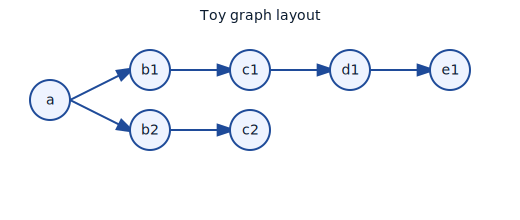

In [4]:
display(render_svg(g, label_col=None, title='Toy graph layout'))


## Exact hops
Exact-hop GFQL edge calls for quick sanity checks before slicing or labeling.


Exactly 1 hop from seed 'a' to its immediate neighbors (no labels).


1-hop nodes from 'a' (first hop):
   id
0   a
1  b1
2  b2

1-hop edges:
   s   d
0  a  b1
1  a  b2


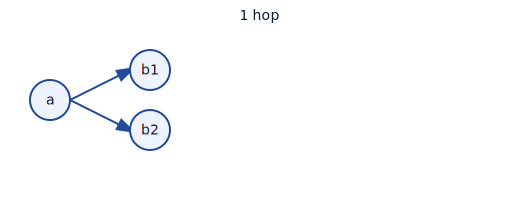

In [5]:
# Exactly 1 hop (no labels)
hop_1 = gfql_hop(min_hops=1, max_hops=1)
print("1-hop nodes from 'a' (first hop):")
print(hop_1._nodes.sort_values(g._node))
print()
print('1-hop edges:')
print(hop_1._edges.sort_values([g._source, g._destination]))
display(render_svg(hop_1, label_col=None, title='1 hop'))


Exactly 3 hops bounded to three steps; default output keeps the earlier hops for context (no labels).


3-hop nodes from 'a' (path to third hop):
   id
5   a
0  b1
3  b2
1  c1
4  c2
2  d1

3-hop edges:
Empty DataFrame
Columns: [s, d]
Index: []


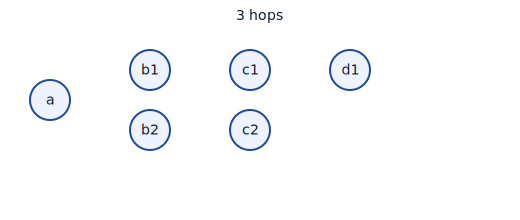

In [6]:
# Exactly 3 hops (no labels, default keeps path)
hop_3 = gfql_hop(min_hops=3, max_hops=3)
print("3-hop nodes from 'a' (path to third hop):")
print(hop_3._nodes.sort_values(g._node))
print()
print('3-hop edges:')
print(hop_3._edges.sort_values([g._source, g._destination]))
display(render_svg(hop_3, label_col=None, title='3 hops'))


## Hop ranges
Variable-length traversal with full-path output (keep hops up to the bound).


Range 1..3 hops from 'a' (unlabeled) to mirror a Cypher pattern like `(a)-[*1..3]->(?)`.


Nodes within 1..3 hops from 'a':
   id
0   a
1  b1
3  b2
2  c1
5  c2
4  d1

Edges within 1..3 hops:
    s   d
0   a  b1
3   a  b2
1  b1  c1
4  b2  c2
2  c1  d1


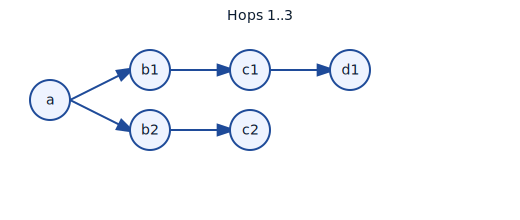

In [7]:
# Range 1..3 hops (combined)
hop_range = gfql_hop(min_hops=1, max_hops=3)
print("Nodes within 1..3 hops from 'a':")
print(hop_range._nodes.sort_values(g._node))
print()
print('Edges within 1..3 hops:')
print(hop_range._edges.sort_values([g._source, g._destination]))
display(render_svg(hop_range, label_col=None, title='Hops 1..3'))


## Output slicing
Post-filter the traversal results without changing the traversal itself.


Traverse 2..4 hops but only display hops 3..4, with hop numbers on nodes/edges.


Nodes in hops 3..4 (after traversing 2..4):
   id  hop
0  d1  3.0
1  e1  4.0
2  c1  NaN

Edges in hops 3..4:
   edge_hop   s   d
0         3  c1  d1
1         4  d1  e1


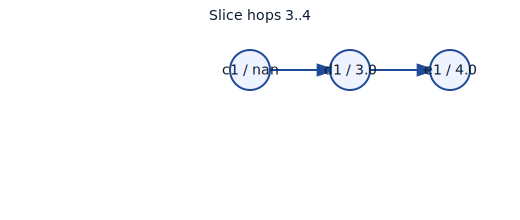

In [8]:
# Traverse 2..4 hops; output slice 3..4 with hop labels
hop_slice = gfql_hop(
    min_hops=2,
    max_hops=4,
    output_min_hops=3,
    output_max_hops=4,
    label_node_hops='hop',
    label_edge_hops='edge_hop'
)
print('Nodes in hops 3..4 (after traversing 2..4):')
print(hop_slice._nodes.sort_values(['hop', g._node]))
print()
print('Edges in hops 3..4:')
print(hop_slice._edges.sort_values(['edge_hop', g._source, g._destination]))
display(render_svg(hop_slice, label_col='hop', title='Slice hops 3..4'))


Output_min below min_hops: keep the lead-in hops and label the seed at hop 0.


Nodes when output_min < min_hops (labels on, seeds labeled):
   id  hop
0  b1  1.0
3  b2  1.0
1  c1  2.0
4  c2  2.0
2  d1  3.0

Edges when output_min < min_hops:
Empty DataFrame
Columns: [edge_hop, s, d]
Index: []


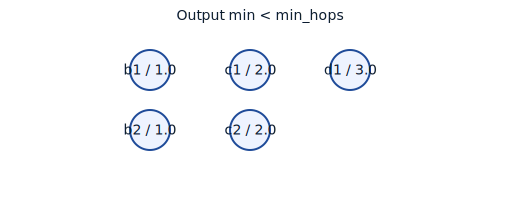

In [9]:
# Output slice below traversal min (keeps earlier hops)
hop_slice_below = gfql_hop(
    min_hops=3,
    max_hops=3,
    output_min_hops=1,
    label_node_hops='hop',
    label_edge_hops='edge_hop',
    label_seeds=True
)
print('Nodes when output_min < min_hops (labels on, seeds labeled):')
print(hop_slice_below._nodes.sort_values(['hop', g._node]))
print()
print('Edges when output_min < min_hops:')
print(hop_slice_below._edges.sort_values(['edge_hop', g._source, g._destination]))
display(render_svg(hop_slice_below, label_col='hop', title='Output min < min_hops'))


Output_max above traversal: slice is capped at traversal depth; edge labels show the cap.


Edges when output_max > traversal max (still capped at traversal):
   edge_hop   s   d
0         1   a  b1
2         1   a  b2
1         2  b1  c1
3         2  b2  c2


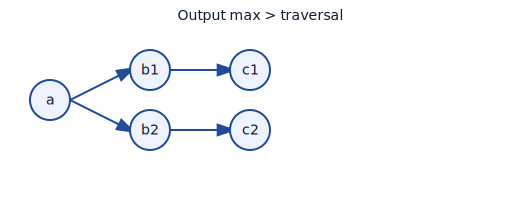

In [10]:
# Output slice max above traversal max (allowed, capped by traversal)
hop_slice_above = gfql_hop(
    min_hops=2,
    max_hops=2,
    output_max_hops=5,
    label_edge_hops='edge_hop'
)
print('Edges when output_max > traversal max (still capped at traversal):')
print(hop_slice_above._edges.sort_values(['edge_hop', g._source, g._destination]))
display(render_svg(hop_slice_above, label_col=None, title='Output max > traversal'))


Invalid output slices: examples of raised validation errors for mismatched bounds.


In [11]:
# Invalid output slice (output_min > max_hops)
try:
    gfql_hop(min_hops=2, max_hops=3, output_min_hops=5)
except Exception as e:
    print('Invalid output_min > max_hops:', e)

# Invalid output slice (output_max < min_hops)
try:
    gfql_hop(min_hops=2, max_hops=3, output_max_hops=1)
except Exception as e:
    print('Invalid output_max < min_hops:', e)


Invalid output_min > max_hops: [invalid-hops-value] output_min_hops cannot exceed max_hops traversal bound | field: output_min_hops | value: 5 | suggestion: Lower output_min_hops or raise max_hops
Invalid output_max < min_hops: [invalid-hops-value] output_max_hops cannot be below min_hops traversal bound | field: output_max_hops | value: 1 | suggestion: Raise output_max_hops or lower min_hops


## Labels
Compare hop labels with and without labeling the seeds.


Labels without seeds: hop numbers start at 1 for new nodes/edges; seed 'a' stays unlabeled.


Nodes with hop labels (seeds not labeled):
   id  hop
1  b1  1.0
3  b2  1.0
2  c1  2.0
5  c2  2.0
4  d1  3.0
0   a  NaN

Edges with hop labels (seeds not labeled):
   edge_hop   s   d
0         1   a  b1
3         1   a  b2
1         2  b1  c1
4         2  b2  c2
2         3  c1  d1


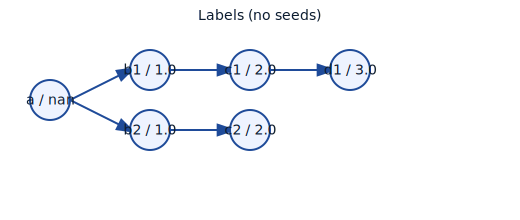

In [12]:
# Hop labels without seed labels
hop_labels_off = gfql_hop(
    min_hops=1,
    max_hops=3,
    label_node_hops='hop',
    label_edge_hops='edge_hop',
    label_seeds=False
)
print('Nodes with hop labels (seeds not labeled):')
print(hop_labels_off._nodes.sort_values(['hop', g._node]))
print()
print('Edges with hop labels (seeds not labeled):')
print(hop_labels_off._edges.sort_values(['edge_hop', g._source, g._destination]))
display(render_svg(hop_labels_off, label_col='hop', title='Labels (no seeds)'))


Labels with seeds: seed labeled hop 0; downstream hops increment from there.


Nodes with hop labels (seeds labeled hop=0):
   id  hop
0   a  0.0
1  b1  1.0
3  b2  1.0
2  c1  2.0
5  c2  2.0
4  d1  3.0

Edges with hop labels (seeds labeled hop=0):
   edge_hop   s   d
0         1   a  b1
3         1   a  b2
1         2  b1  c1
4         2  b2  c2
2         3  c1  d1


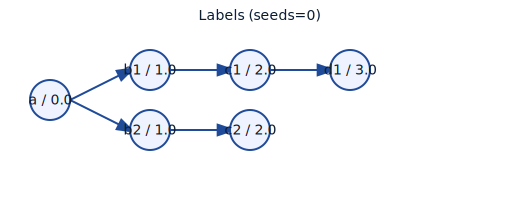

In [13]:
# Hop labels with seed labels
hop_labels_on = gfql_hop(
    min_hops=1,
    max_hops=3,
    label_node_hops='hop',
    label_edge_hops='edge_hop',
    label_seeds=True
)
print('Nodes with hop labels (seeds labeled hop=0):')
print(hop_labels_on._nodes.sort_values(['hop', g._node]))
print()
print('Edges with hop labels (seeds labeled hop=0):')
print(hop_labels_on._edges.sort_values(['edge_hop', g._source, g._destination]))
display(render_svg(hop_labels_on, label_col='hop', title='Labels (seeds=0)'))
